In [1]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr="add", node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(
        self,
        x_j: Tensor,
        x_i: Tensor,
        edge_attr: Tensor,
        index: Tensor,
        ptr: OptTensor,
        size_i: Optional[int],
    ) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """

    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim, dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(
                hidden_channels,
                hidden_channels,
                dropout=dropout,
                add_self_loops=False,
                negative_slope=0.01,
            )
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(
            hidden_channels,
            hidden_channels,
            dropout=dropout,
            add_self_loops=False,
            negative_slope=0.01,
        )
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)
        self.first_gat_attention_weights = None
        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(
        self, x: Tensor, edge_index: Tensor, edge_attr: Tensor, batch: Tensor
    ) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        # MODIFIED SECTION TO CAPTURE ATTENTION
        self.first_gat_attention_weights = None
        first_gat_conv_processed = False

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            if not first_gat_conv_processed and isinstance(conv, GATConv):
                # This is the first GATConv in the atom_convs list
                h_gat, attention_weights_tuple = conv(
                    x, edge_index, return_attention_weights=True
                )
                self.first_gat_attention_weights = attention_weights_tuple
                first_gat_conv_processed = True
                h = h_gat  # Use the output from the GATConv
            else:
                h = conv(x, edge_index)

            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()
        # END OF MODIFIED SECTION

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            # print(f"Before: {h.shape}")
            h = conv(x, edge_index)
            # print(f"after: {h.shape}")
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()
        self.embedding = x
        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}("
            f"in_channels={self.in_channels}, "
            f"hidden_channels={self.hidden_channels}, "
            f"out_channels={self.out_channels}, "
            f"edge_dim={self.edge_dim}, "
            f"num_layers={self.num_layers}, "
            f"num_timesteps={self.num_timesteps}"
            f")"
        )

In [2]:
import os.path as osp
from math import sqrt

from rdkit import Chem

from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from tqdm import trange
import sys

import random

random.seed(42)


class GenFeatures:
    def __init__(self):
        self.symbols = [
            "B",
            "C",
            "N",
            "O",
            "F",
            "Si",
            "P",
            "S",
            "Cl",
            "As",
            "Se",
            "Br",
            "Te",
            "I",
            "At",
            "other",
        ]

        self.hybridizations = [
            Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2,
            Chem.rdchem.HybridizationType.SP3,
            Chem.rdchem.HybridizationType.SP3D,
            Chem.rdchem.HybridizationType.SP3D2,
            "other",
        ]

        self.stereos = [
            Chem.rdchem.BondStereo.STEREONONE,
            Chem.rdchem.BondStereo.STEREOANY,
            Chem.rdchem.BondStereo.STEREOZ,
            Chem.rdchem.BondStereo.STEREOE,
        ]

    def __call__(self, data):
        # Generate AttentiveFP features according to Table 1.
        mol = Chem.MolFromSmiles(data.smiles)

        xs = []
        for atom in mol.GetAtoms():
            symbol = [0.0] * len(self.symbols)
            symbol[self.symbols.index(atom.GetSymbol())] = 1.0
            degree = [0.0] * 6
            degree[atom.GetDegree()] = 1.0
            formal_charge = atom.GetFormalCharge()
            radical_electrons = atom.GetNumRadicalElectrons()
            hybridization = [0.0] * len(self.hybridizations)
            hybridization[self.hybridizations.index(atom.GetHybridization())] = 1.0
            aromaticity = 1.0 if atom.GetIsAromatic() else 0.0
            hydrogens = [0.0] * 5
            hydrogens[atom.GetTotalNumHs()] = 1.0
            chirality = 1.0 if atom.HasProp("_ChiralityPossible") else 0.0
            chirality_type = [0.0] * 2
            if atom.HasProp("_CIPCode"):
                chirality_type[["R", "S"].index(atom.GetProp("_CIPCode"))] = 1.0

            x = torch.tensor(
                symbol
                + degree
                + [formal_charge]
                + [radical_electrons]
                + hybridization
                + [aromaticity]
                + hydrogens
                + [chirality]
                + chirality_type
            )
            xs.append(x)

        data.x = torch.stack(xs, dim=0)

        edge_indices = []
        edge_attrs = []
        for bond in mol.GetBonds():
            edge_indices += [[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]]
            edge_indices += [[bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]]

            bond_type = bond.GetBondType()
            single = 1.0 if bond_type == Chem.rdchem.BondType.SINGLE else 0.0
            double = 1.0 if bond_type == Chem.rdchem.BondType.DOUBLE else 0.0
            triple = 1.0 if bond_type == Chem.rdchem.BondType.TRIPLE else 0.0
            aromatic = 1.0 if bond_type == Chem.rdchem.BondType.AROMATIC else 0.0
            conjugation = 1.0 if bond.GetIsConjugated() else 0.0
            ring = 1.0 if bond.IsInRing() else 0.0
            stereo = [0.0] * 4
            stereo[self.stereos.index(bond.GetStereo())] = 1.0

            edge_attr = torch.tensor(
                [single, double, triple, aromatic, conjugation, ring] + stereo
            )

            edge_attrs += [edge_attr, edge_attr]

        if len(edge_attrs) == 0:
            data.edge_index = torch.zeros((2, 0), dtype=torch.long)
            data.edge_attr = torch.zeros((0, 10), dtype=torch.float)
        else:
            data.edge_index = torch.tensor(edge_indices).t().contiguous()
            data.edge_attr = torch.stack(edge_attrs, dim=0)

        return data


path = osp.join("data", "AFP_Mol")
dataset = MoleculeNet(path, name="ESOL", pre_transform=GenFeatures()).shuffle()

N = len(dataset) // 10
val_dataset = dataset[:N]
test_dataset = dataset[N : 2 * N]
train_dataset = dataset[2 * N :]

train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=200)
test_loader = DataLoader(test_dataset, batch_size=200)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentiveFP(
    in_channels=39,
    hidden_channels=200,
    out_channels=1,
    edge_dim=10,
    num_layers=2,
    num_timesteps=2,
    dropout=0.2,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=10**-2.5, weight_decay=10**-5)


def train():
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
    return sqrt(total_loss / total_examples)


@torch.no_grad()
def test(loader):
    mse = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        mse.append(F.mse_loss(out, data.y, reduction="none").cpu())
    return float(torch.cat(mse, dim=0).mean().sqrt())

In [3]:
for epoch in (pbar := trange(1, 50, ncols=100)):
    train_rmse = train()
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    pbar.set_postfix({"train": train_rmse, "val": val_rmse, "test": test_rmse})
    # print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} Val: {val_rmse:.4f} '
    #       f'Test: {test_rmse:.4f}')


100%|████████████████████████████| 49/49 [00:47<00:00,  1.03it/s, train=0.56, val=0.649, test=0.672]


Cc1cc(=O)n(c2ccccc2)n1C


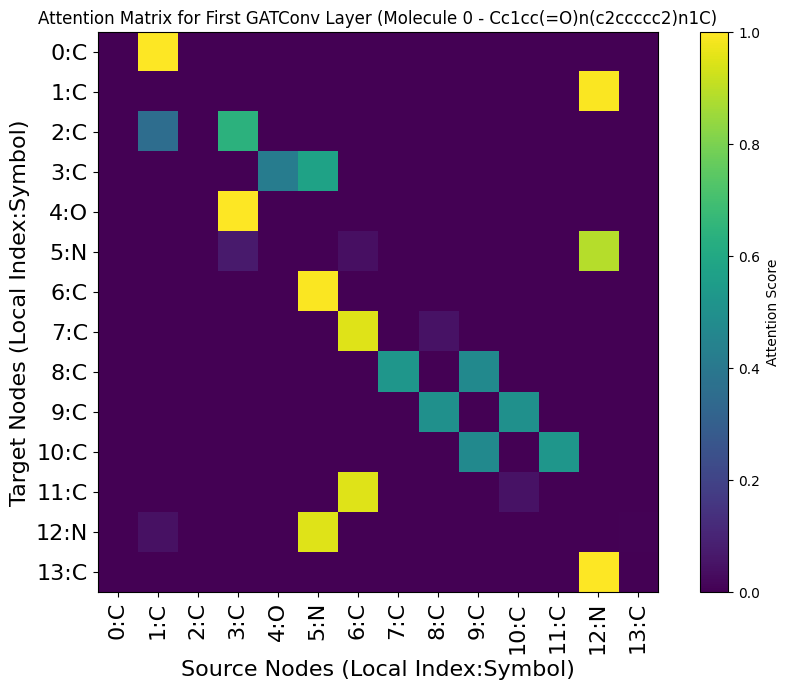

In [20]:
# This code should be placed in a new cell (e.g., cell 6)

import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
import torch  # Ensure torch is available, though likely already imported

# Ensure the model is in evaluation mode
model.eval()
# Get a sample batch from the test_loader
try:
    iter1 = iter(test_loader)
    data_sample = next(iter1)
    data_sample = data_sample.to(device)
except StopIteration:
    print("Test loader is empty. Cannot generate attention map.")
    # Or handle this scenario as appropriate

if "data_sample" in locals():
    with torch.no_grad():
        # Perform a forward pass to populate model.first_gat_attention_weights
        out = model(
            data_sample.x,
            data_sample.edge_index,
            data_sample.edge_attr,
            data_sample.batch,
        )

    if model.first_gat_attention_weights is None:
        print("No attention weights captured from the first GATConv layer.")
        print(
            "This might happen if num_layers < 2, or if the model structure was modified."
        )
    else:
        # att_edge_index is global for the batch
        att_edge_index, att_scores = model.first_gat_attention_weights
        # att_scores shape: (E_batch, num_heads). GATConv in AttentiveFP has heads=1.
        att_scores = att_scores.squeeze(-1).cpu()  # Shape: (E_batch), move to CPU
        att_edge_index = att_edge_index.cpu()  # Move to CPU

        # --- Process data for the first molecule (mol_idx = 0) ---
        mol_idx = 0

        # Nodes belonging to the first molecule
        node_mask_mol0 = data_sample.batch.cpu() == mol_idx
        nodes_mol0_global_indices = torch.where(node_mask_mol0)[0]

        if len(nodes_mol0_global_indices) == 0:
            print(f"Molecule {mol_idx} in the sample has no nodes.")
        else:
            num_nodes_mol0 = nodes_mol0_global_indices.size(0)

            # Create a mapping from global node index to local index for molecule 0
            global_to_local_idx_mol0 = {
                global_idx.item(): local_idx
                for local_idx, global_idx in enumerate(nodes_mol0_global_indices)
            }

            # Filter edges and attention scores for molecule 0
            # An edge (u,v) is in molecule 0 if both u and v are in nodes_mol0_global_indices
            edge_src_is_in_mol0 = torch.isin(
                att_edge_index[0], nodes_mol0_global_indices
            )
            edge_dst_is_in_mol0 = torch.isin(
                att_edge_index[1], nodes_mol0_global_indices
            )
            mol0_edge_mask = edge_src_is_in_mol0 & edge_dst_is_in_mol0

            mol0_att_edge_index_global = att_edge_index[:, mol0_edge_mask]
            mol0_att_scores = att_scores[mol0_edge_mask]

            # Convert global edge indices to local indices for molecule 0
            if mol0_att_edge_index_global.numel() > 0:
                mol0_att_edge_index_local_src = torch.tensor(
                    [
                        global_to_local_idx_mol0[idx.item()]
                        for idx in mol0_att_edge_index_global[0]
                    ]
                )
                mol0_att_edge_index_local_dst = torch.tensor(
                    [
                        global_to_local_idx_mol0[idx.item()]
                        for idx in mol0_att_edge_index_global[1]
                    ]
                )
            else:  # Handle case with no edges in the first molecule after filtering
                mol0_att_edge_index_local_src = torch.empty(0, dtype=torch.long)
                mol0_att_edge_index_local_dst = torch.empty(0, dtype=torch.long)

            # Construct attention matrix for molecule 0
            # A[i, j] = attention from node j to node i
            attention_matrix_mol0 = torch.zeros((num_nodes_mol0, num_nodes_mol0))
            if mol0_att_scores.numel() > 0:
                attention_matrix_mol0[
                    mol0_att_edge_index_local_dst, mol0_att_edge_index_local_src
                ] = mol0_att_scores

            # --- Plotting ---
            # Get atom symbols for labels
            atom_symbols_mol0 = []
            if mol_idx < len(data_sample.smiles):
                smiles_mol0 = data_sample.smiles[mol_idx]
                mol_rdkit_mol0 = Chem.MolFromSmiles(smiles_mol0)
                if mol_rdkit_mol0:
                    atom_symbols_mol0 = [
                        atom.GetSymbol() for atom in mol_rdkit_mol0.GetAtoms()
                    ]

            if len(atom_symbols_mol0) == num_nodes_mol0:
                tick_labels_mol0 = [f"{i}:{s}" for i, s in enumerate(atom_symbols_mol0)]
            else:
                print(
                    f"Warning: Atom symbol count ({len(atom_symbols_mol0)}) mismatch with node count ({num_nodes_mol0}). Using numerical labels."
                )
                tick_labels_mol0 = np.arange(num_nodes_mol0)

            plt.figure(
                figsize=(max(6, num_nodes_mol0 / 1.5), max(5, num_nodes_mol0 / 2))
            )  # Adjust size
            plt.imshow(
                attention_matrix_mol0.numpy(),
                cmap="viridis",
                interpolation="nearest",
                aspect="equal",
            )
            plt.colorbar(label="Attention Score")
            plt.title(
                f"Attention Matrix for First GATConv Layer (Molecule {mol_idx} - {smiles_mol0 if mol_idx < len(data_sample.smiles) else ''})"
            )

            if num_nodes_mol0 > 0:
                plt.xticks(
                    np.arange(num_nodes_mol0), labels=tick_labels_mol0, rotation=90
                )
                plt.yticks(np.arange(num_nodes_mol0), labels=tick_labels_mol0)

            # increase font size for better readability
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            plt.xlabel("Source Nodes (Local Index:Symbol)", fontsize=16)
            plt.ylabel("Target Nodes (Local Index:Symbol)", fontsize=16)

            plt.tight_layout()
            print(smiles_mol0)
            plt.savefig(
                f"attention_matrix_mol_{mol_idx}.png",
                bbox_inches="tight",
                dpi=300,
            )
            plt.show()
            # save

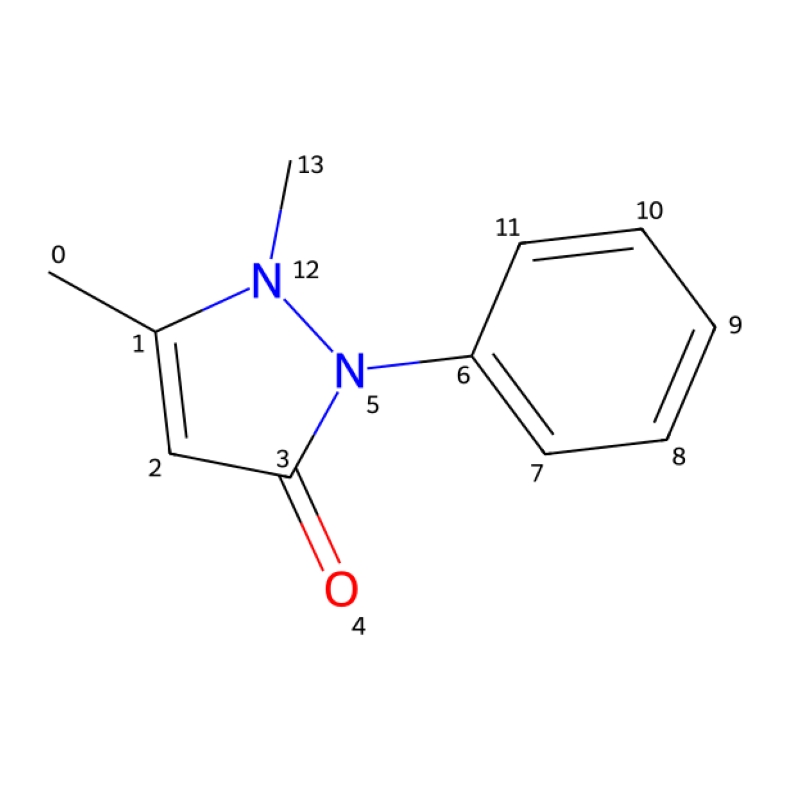

SMILES: Cc1cc(=O)n(c2ccccc2)n1C


In [16]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
import os

import matplotlib.pyplot as plt


def visualize_molecule_with_indices(smiles):
    """
    Visualize a molecule from SMILES string with atom indices displayed.

    Args:
        smiles (str): SMILES string representation of the molecule
    """
    # Create molecule from SMILES
    mol = Chem.MolFromSmiles(smiles.strip())

    if mol is not None:
        # Add atom indices to the molecule for visualization
        for atom in mol.GetAtoms():
            atom.SetProp("atomNote", str(atom.GetIdx()))

        # Create a 2D drawing
        drawer = rdMolDraw2D.MolDraw2DCairo(600, 600)
        drawer.DrawMolecule(mol)
        drawer.FinishDrawing()

        # Get the image as PNG bytes and convert to PIL Image
        img_bytes = drawer.GetDrawingText()
        with open("temp_mol.png", "wb") as f:
            f.write(img_bytes)

        # Load and display the image
        img = Image.open("temp_mol.png")

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        # save to file
        img.save("molecule_with_indices.png")
        print(f"SMILES: {smiles.strip()}")

        # Clean up temporary file
        os.remove("temp_mol.png")
    else:
        print("Could not create molecule from SMILES string")


# Use the function with the existing SMILES
visualize_molecule_with_indices(smiles_mol0)

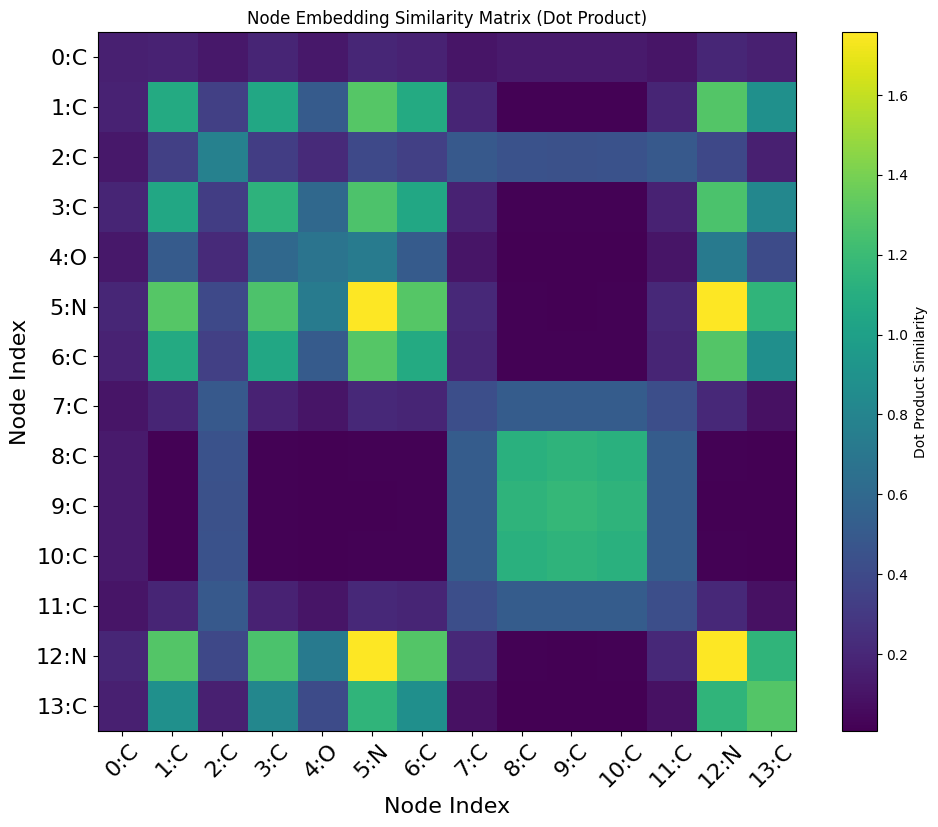

Similarity matrix shape: (14, 14)
Min similarity: 0.0079
Max similarity: 1.7573
Molecular SMILES: Cc1cc(=O)n(c2ccccc2)n1C
Chemical Formula: ['C', 'C', 'C', 'C', 'O', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'N', 'C']


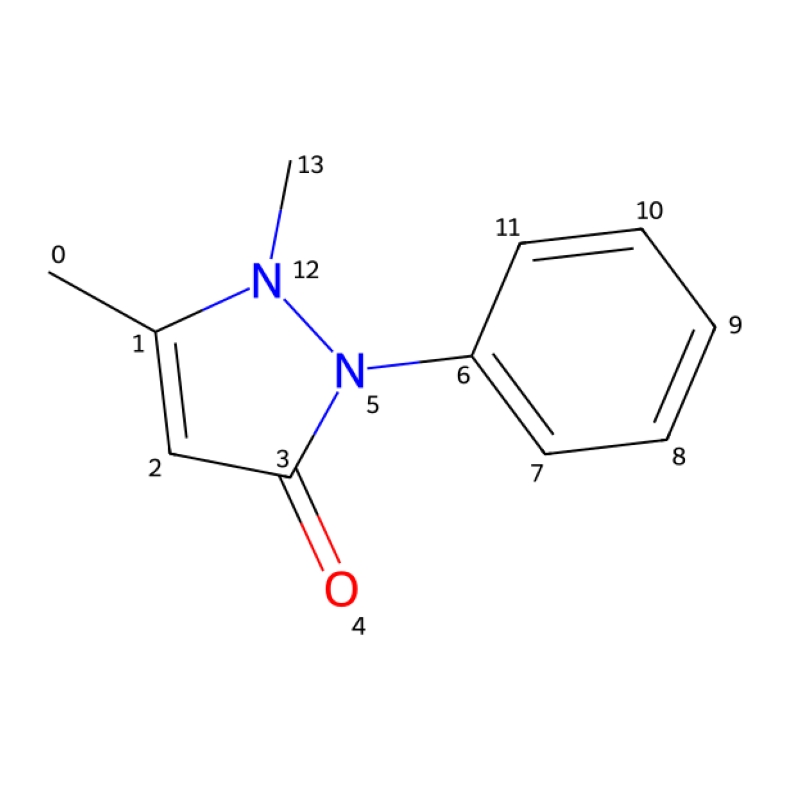

SMILES: Cc1cc(=O)n(c2ccccc2)n1C


In [19]:
first = "none"
target = smiles_mol0
# search for the first molecule with the target SMILES
for d in dataset:
    if d.smiles == target:
        first = d
        break


out = model(first.x, first.edge_index, first.edge_attr, torch.tensor([0]))
model.embedding
# Calculate dot product similarity matrix from embeddings
embedding_matrix = model.embedding.detach().cpu().numpy()
similarity_matrix = np.dot(embedding_matrix, embedding_matrix.T)

# Plot the similarity matrix
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Dot Product Similarity")
plt.title("Node Embedding Similarity Matrix (Dot Product)")
plt.xlabel("Node Index", fontsize=16)
plt.ylabel("Node Index", fontsize=16)
plt.tight_layout()
# Add atom labels to the similarity matrix plot
atom_symbols = []
if first.smiles:
    mol_rdkit = Chem.MolFromSmiles(first.smiles)
    if mol_rdkit:
        atom_symbols = [atom.GetSymbol() for atom in mol_rdkit.GetAtoms()]

if len(atom_symbols) == similarity_matrix.shape[0]:
    tick_labels = [f"{i}:{s}" for i, s in enumerate(atom_symbols)]
    plt.xticks(range(len(tick_labels)), tick_labels, rotation=45, fontsize=16)
    plt.yticks(range(len(tick_labels)), tick_labels, fontsize=16)
else:
    # Fallback to numerical labels if symbols don't match
    plt.xticks(range(similarity_matrix.shape[0]), fontsize=16)
    plt.yticks(range(similarity_matrix.shape[1]), fontsize=16)
plt.savefig("similarity_matrix.png", bbox_inches="tight", dpi=300)
plt.show()
print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"Min similarity: {similarity_matrix.min():.4f}")
print(f"Max similarity: {similarity_matrix.max():.4f}")
print(f"Molecular SMILES: {first.smiles}")
print(
    f"Chemical Formula: {[a.GetSymbol() for a in Chem.MolFromSmiles(first.smiles).GetAtoms()]}"
)
visualize_molecule_with_indices(first.smiles)
